In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc


In [2]:
diff = "5percent"
pressure = 1

# Set the detector size depending on the pressure
density = 5.987*pressure
M = 1000/0.9
det_size = 1000*np.cbrt((4 * M) / (np.pi * density))/2.0
print(det_size)

# Load in the signal metadata
nubb_meta = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_{pressure}bar_{diff}_reco.h5", "meta")
nubb_meta["Type"] = "0nubb"
nubb_meta = nubb_meta[nubb_meta.label == "Primary"]
nubb_meta = nubb_meta[["length","energy", "blob1", "blob2", "Type"] ]
display(nubb_meta)

# ----------------------------------------------------------------------------------------------------

# Load in the background
Bkg_meta = pd.DataFrame()
Tl_meta = pd.DataFrame()
Bi_meta = pd.DataFrame()

Tl_meta = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_ion_{pressure}bar_{diff}_reco.h5", "meta")
Tl_meta["Type"] = "Tl"
Bi_meta = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_ion_{pressure}bar_{diff}_reco.h5", "meta")
Bi_meta["Type"] = "Bi"
single_meta = pd.read_hdf(f"../data/Trackreco/ATPC_single_{pressure}bar_{diff}_reco.h5", "meta")
single_meta["Type"] = "single"

Bkg_meta = pd.concat([Tl_meta, Bi_meta, single_meta])
# Bkg_meta = pd.concat([Tl_meta])


Bkg_meta = Bkg_meta[Bkg_meta.label == "Primary"]
Bkg_meta = Bkg_meta[ ["length","energy", "blob1", "blob2", "Type"] ]
Bkg_meta["Type"] = "Bkg"


display(Bkg_meta)

df = pd.concat([nubb_meta, Bkg_meta])


3091.169274839764


,length,energy,blob1,blob2,Type
0,4276.852,2.438185,0.488709,0.447872,0nubb
0,2657.140,2.251336,0.571660,0.477068,0nubb
0,2814.044,2.276025,0.680826,0.631880,0nubb
0,3644.610,2.425680,0.716968,0.566462,0nubb
0,2727.812,2.436129,0.873766,0.568308,0nubb
...,...,...,...,...,...
0,4091.788,2.474941,0.480529,0.426895,0nubb
0,3576.613,2.449050,0.700067,0.511681,0nubb
0,2773.146,2.460507,0.641220,0.456344,0nubb
0,3615.915,2.397672,0.566292,0.447554,0nubb


,length,energy,blob1,blob2,Type
0,3489.334,2.179821,0.477686,0.277187,Bkg
0,4050.934,2.367837,0.519893,0.319599,Bkg
0,3346.264,2.349994,0.541380,0.414271,Bkg
0,3355.528,2.129206,0.496338,0.232579,Bkg
0,1403.684,0.763265,0.365415,0.225305,Bkg
...,...,...,...,...,...
0,4009.606,2.453905,0.609179,0.365327,Bkg
0,4131.541,2.466757,0.591379,0.348602,Bkg
0,4162.138,2.452447,0.494766,0.224080,Bkg
0,2807.946,2.216093,0.675939,0.316993,Bkg


In [3]:
# Normalize the columns

def normalize_cols(df, columns):
    result = df.copy()
    for col in columns:
        max_val = df[col].max()
        min_val = df[col].min()
        # Prevent division by zero if all values are the same
        if max_val == min_val:
            result[col] = 0
        else:
            result[col] = (df[col] - min_val) / (max_val - min_val)
    return result

cols = ["length", "energy", "blob1", "blob2"]

df = normalize_cols(df, cols)
display(df)
df.describe()

,length,energy,blob1,blob2,Type
0,0.750974,0.982111,0.196790,0.361191,0nubb
0,0.466155,0.906735,0.230215,0.384753,0nubb
0,0.493746,0.916694,0.274202,0.509693,0nubb
0,0.639797,0.977066,0.288765,0.456897,0nubb
0,0.478582,0.981282,0.351945,0.458388,0nubb
...,...,...,...,...,...
0,0.703980,0.988452,0.245332,0.294574,Bkg
0,0.725422,0.993637,0.238160,0.281076,Bkg
0,0.730802,0.987864,0.199231,0.180581,Bkg
0,0.492673,0.892517,0.272233,0.255566,Bkg


,length,energy,blob1,blob2
count,791714.000000,791714.000000,791714.000000,791714.000000
mean,0.562650,0.872765,0.234778,0.266312
std,0.131263,0.135106,0.070979,0.107529
min,0.000000,0.000000,0.000000,0.000000
25%,0.508417,0.814424,0.202477,0.186530
50%,0.581055,0.914178,0.229082,0.230896
75%,0.644777,0.980102,0.258391,0.348196
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
features = ['length', 'energy', 'blob1', 'blob2']

X = df[features]
y = (df['Type'] == '0nubb').astype('int')

# Print the total events with a mapping
mapping = {1: '0nubb', 0: 'Bkg'}
print(y.value_counts().rename(index=mapping))

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42 )

Type
Bkg      599427
0nubb    192287
Name: count, dtype: int64


In [5]:
X_train_tensor = torch.tensor(X_train.astype('float32').values, dtype=torch.float32)
y_train_tensor = torch.tensor( y_train.astype('float32').values,dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val.astype('float32').values,dtype=torch.float32 )
y_val_tensor = torch.tensor( y_val.astype('float32').values, dtype=torch.float32).unsqueeze(1)

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4096, shuffle=False)


In [ ]:
def accuracy_from_logits(logits, y_true, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    return (preds == y_true).float().mean().item()


model = SimpleMLP()

pos_weight = torch.tensor([4.0])  # background:signal = 4:1

# Binary cross entropy loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam( model.parameters(), lr=1e-3, weight_decay=1e-4)


train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(50):

    # -------- training --------
    # Put the model in training mode, gradients will be computed
    model.train() 
    train_loss = 0.0 # Sum the loss over all batches, then average it

    # Loop over training batches
    for xb, yb in train_loader:
        optimizer.zero_grad()        # Clear old features
        logits = model(xb)           # Data flows through the network, the output is called logits (raw scores not probabilities)
        loss = criterion(logits, yb) # Compares the predictions (logits) with the true labels (yb)
        loss.backward()              # Computes the gradients of the loss (stored in param.grad for every model param)
        optimizer.step()             # Uses the gradients to update the weights. Depends on the optimizer e.g. SGD, Adam etc -- this is the learning step

        train_loss += loss.item() * xb.size(0) # Accumulates the total loss. loss.item() = average loss per sample in the batch, xb.size() = batch size

    train_loss /= len(train_loader.dataset) # Average the training loss over the total dataset
    train_loss_hist.append(train_loss)

    # -------- validation --------
    model.eval() # Disables dropout, freezes batchnorm statistics, ensures deterministic behaviour
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad(): # Disables gradient tracking (saves memory, speeds up evalulation, prevents accidental backpropagation)
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            val_acc += accuracy_from_logits(logits, yb) * xb.size(0) # Converts logits -> predicted class, compares with yb

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {val_acc:.3f}"
    )

Epoch 001 | Train loss: 0.7614 | Val loss: 0.5820 | Val acc: 0.850
Epoch 002 | Train loss: 0.5617 | Val loss: 0.5550 | Val acc: 0.856
Epoch 003 | Train loss: 0.5455 | Val loss: 0.5483 | Val acc: 0.864
Epoch 004 | Train loss: 0.5422 | Val loss: 0.5465 | Val acc: 0.870
Epoch 005 | Train loss: 0.5404 | Val loss: 0.5449 | Val acc: 0.864
Epoch 006 | Train loss: 0.5393 | Val loss: 0.5444 | Val acc: 0.863
Epoch 007 | Train loss: 0.5387 | Val loss: 0.5442 | Val acc: 0.863
Epoch 008 | Train loss: 0.5382 | Val loss: 0.5441 | Val acc: 0.861
Epoch 009 | Train loss: 0.5380 | Val loss: 0.5429 | Val acc: 0.863
Epoch 010 | Train loss: 0.5375 | Val loss: 0.5432 | Val acc: 0.861
Epoch 011 | Train loss: 0.5370 | Val loss: 0.5420 | Val acc: 0.868
Epoch 012 | Train loss: 0.5367 | Val loss: 0.5429 | Val acc: 0.870
Epoch 013 | Train loss: 0.5365 | Val loss: 0.5416 | Val acc: 0.870
Epoch 014 | Train loss: 0.5362 | Val loss: 0.5417 | Val acc: 0.863
Epoch 015 | Train loss: 0.5356 | Val loss: 0.5414 | Val acc: 0

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_val_tensor)
    scores = torch.sigmoid(logits).cpu().numpy().ravel() # converts logits back to probability
    labels = y_val_tensor.cpu().numpy().ravel()

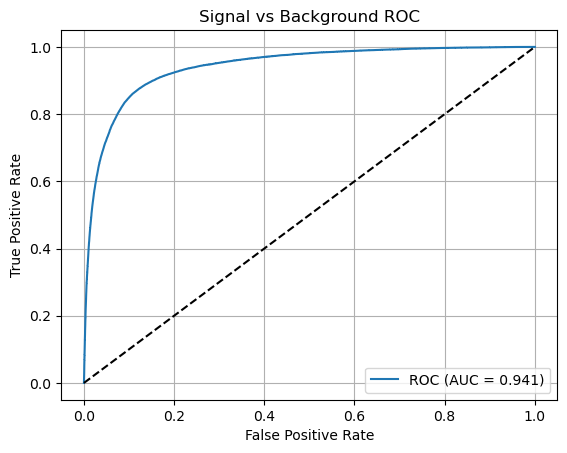

In [26]:
fpr, tpr, thresholds = roc_curve(y_val, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal vs Background ROC')
plt.legend()
plt.grid(True)
plt.show()


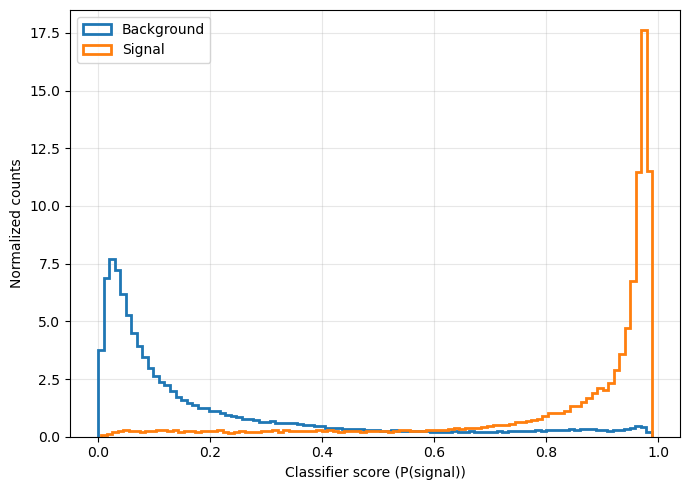

0.5775021452531399 0.9763108286205229


In [36]:
signal_scores     = scores[labels == 1]
background_scores = scores[labels == 0]

plt.figure(figsize=(7,5))

bins = 100

plt.hist(background_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Background')
plt.hist(signal_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Signal')

plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

cut = 0.92
signal_eff = (signal_scores > cut).mean()
bkg_rej = 1 - (background_scores > cut).mean()
print(signal_eff, bkg_rej)

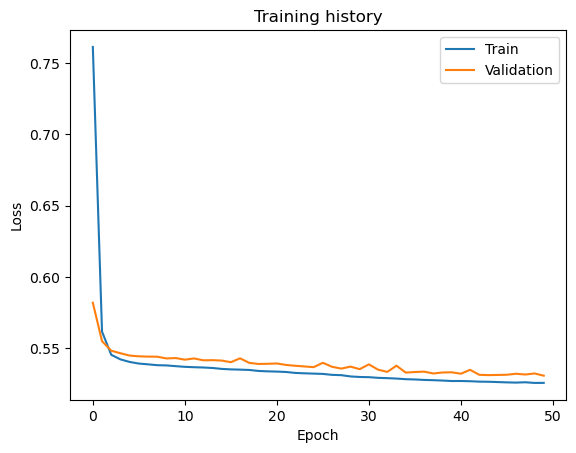

In [11]:


plt.figure()
plt.plot(train_loss_hist, label='Train')
plt.plot(val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training history')
plt.show()



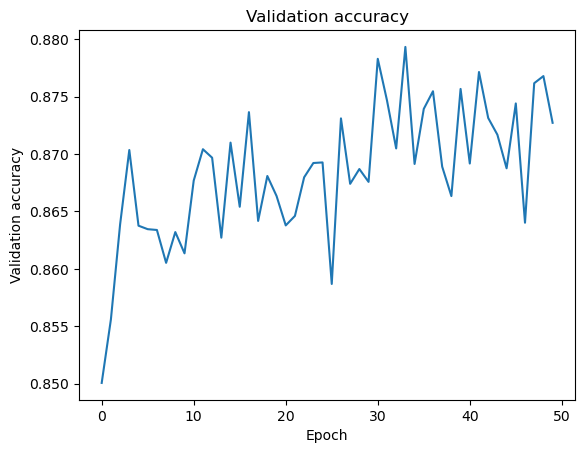

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/krishan.mistry/miniconda3/envs/mistry/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py", line 575, in _log_error
    f.result()
    ~~~~~~~~^^
  File "/Users/krishan.mistry/miniconda3/envs/mistry/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 643, in shell_channel_thread_main
    _, msg2 = self.session.feed_identities(msg, copy=False)
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/Users/krishan.mistry/miniconda3/envs/mistry/lib/python3.13/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/krishan.mistry/miniconda3/envs/mistry/lib/python3.13/site-packages/zmq/eventloop/zmqstream.py", line 575, in _log_error
    f.result()
    ~~~~~~~~^^
  File "

In [25]:
plt.figure()
plt.plot(val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy')
plt.show()